In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf


## 1. General overview of columns and values 

In [311]:
df = pd.read_csv("Test_task_payments.csv")
df.head()

,order_id,user_id,transactions_amount,transactions_currency,product_type_id,timestamp,charge_type,status,card_country,card_bin,card_bank,card_brand,is_chargeback,is_refunded
0,4780209614041198617,5315216,1317,USD,1,2022-10-25 02:05:20.000000,recurring,fail,USA,423223,THE BANCORP BANK,VISA,0,0
1,7674073830916597766,5803988,1578,AUD,3,2023-01-19 05:16:38.000000,recurring,success,AUS,401795,NATIONAL AUSTRALIA BANK LIMITED,VISA,0,1
2,2761093833580728938,2966070,2753,AUD,2,2022-10-08 22:17:48.000000,recurring,fail,AUS,434968,BANK OF QUEENSLAND LIMITED,VISA,0,0
3,272330998285828828,7919216,1960,USD,1,2023-02-19 21:01:46.000000,recurring,fail,USA,559578,SPOKANE TEACHERS CREDIT UNION,MASTERCARD,0,0
4,8394483922195685835,5964168,4146,GBP,1,2022-10-16 03:00:41.000000,recurring,fail,GBR,465865,BARCLAYS BANK UK PLC,VISA,0,0


In [312]:
df.shape # (320708, 16)
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320708 entries, 0 to 320707
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   order_id               320708 non-null  int64 
 1   user_id                320708 non-null  int64 
 2   transactions_amount    320708 non-null  int64 
 3   transactions_currency  320708 non-null  object
 4   product_type_id        320708 non-null  int64 
 5   timestamp              320708 non-null  object
 6   charge_type            320708 non-null  object
 7   status                 320708 non-null  object
 8   card_country           320708 non-null  object
 9   card_bin               320708 non-null  int64 
 10  card_bank              320582 non-null  object
 11  card_brand             320708 non-null  object
 12  is_chargeback          320708 non-null  int64 
 13  is_refunded            320708 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 34.3+ MB


order_id                   0
user_id                    0
transactions_amount        0
transactions_currency      0
product_type_id            0
timestamp                  0
charge_type                0
status                     0
card_country               0
card_bin                   0
card_bank                126
card_brand                 0
is_chargeback              0
is_refunded                0
dtype: int64

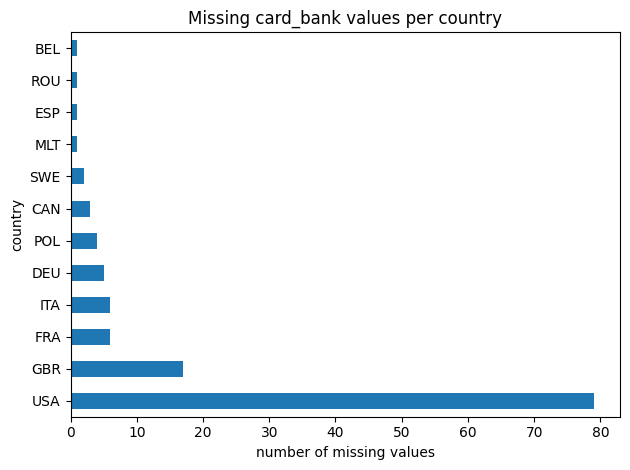

In [313]:
card_bank_null = df[df['card_bank'].isna()]
country_counts = card_bank_null['card_country'].value_counts()

country_counts.plot(kind='barh')
plt.title('Missing card_bank values per country')
plt.xlabel('number of missing values')
plt.ylabel('country')
plt.tight_layout()
plt.show()


Drop missing values 

In [314]:
df = df[df['card_bank'].notna()]
# df.isna().sum() 

Explore uniquie values of each column

In [315]:
df_columns  = ['transactions_currency', 'product_type_id', 'charge_type', 'status', 'card_country', 'card_bin', 'card_bank', 'card_brand']
for col in df_columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("=" * 40)


Column: transactions_currency
['USD' 'AUD' 'GBP' 'EUR' 'CAD' 'NZD' 'SEK' 'PLN' 'NOK' 'DKK']
Column: product_type_id
[1 3 2 5 6 4]
Column: charge_type
['recurring' 'trial']
Column: status
['fail' 'success' 'verify']
Column: card_country
['USA' 'AUS' 'GBR' 'FRA' 'CAN' 'NZL' 'ESP' 'SWE' 'ITA' 'POL' 'IRL' 'FIN'
 'NLD' 'LTU' 'NOR' 'ROU' 'HRV' 'DNK' 'CZE' 'DEU' 'AUT' 'SVK' 'BGR' 'LVA'
 'PRT' 'GRC' 'HUN' 'ISL' 'MLT' 'EST' 'GIB' 'LIE' 'BEL' 'SVN' 'LUX']
Column: card_bin
[423223 401795 434968 ... 472684 510909 411457]
Column: card_bank
['THE BANCORP BANK' 'NATIONAL AUSTRALIA BANK LIMITED'
 'BANK OF QUEENSLAND LIMITED' ... 'LAPORTE COMMUNITY FEDERAL CREDIT UNION'
 'FIRST BANK S.A.' 'COMMUNITY BANK OF PLEASANT HILL']
Column: card_brand
['VISA' 'MASTERCARD']


In [316]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
latest = df['timestamp'].max().date()
earliest = df['timestamp'].min().date()
print(f"Time period: ({earliest} - {latest}) [{(latest - earliest).days} days]")

Time period: (2022-10-01 - 2023-02-28) [150 days]


In [317]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
full_range = pd.date_range(start = df['date'].min(), end = df['date'].max(), freq='D').date
active_dates = set(df['date'])

missing_dates = sorted(set(full_range) - active_dates)

if missing_dates == []:
        print("There are no days with missing transactions =)")
else:
    print(missing_dates)

There are no days with missing transactions =)


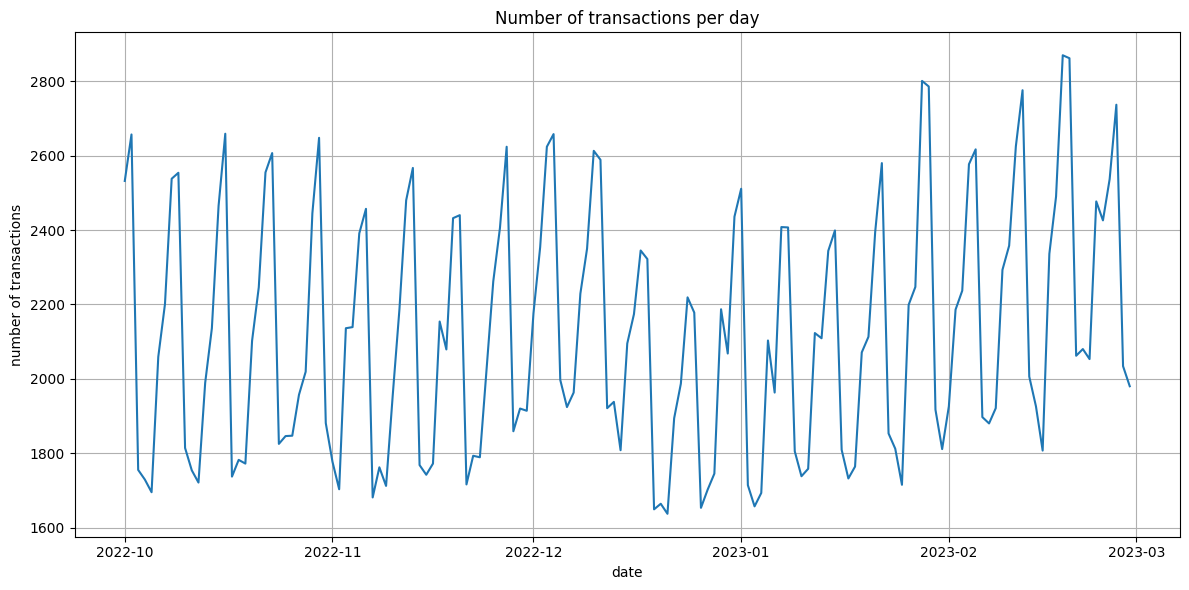

In [318]:
daily_transactions = df.groupby('date').size()
plt.figure(figsize=(12, 6))
daily_transactions.plot(kind='line')
plt.title('Number of transactions per day')
plt.xlabel('date')
plt.ylabel('number of transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

Here we can see weklly seasonality of  transactions

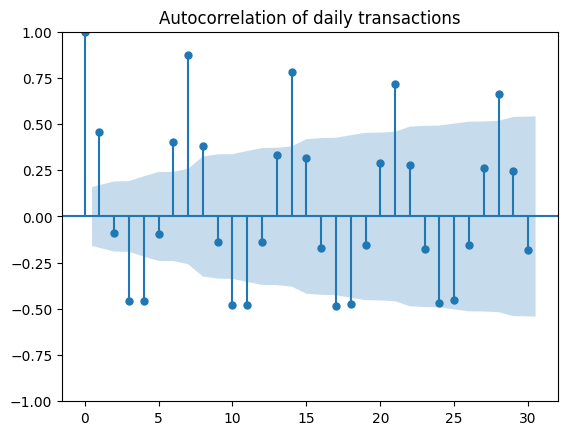

In [319]:
plot_acf(daily_transactions, lags=30)
plt.title("Autocorrelation of daily transactions")
plt.show()


The highest number of transactions occurs on Saturday and Sunday

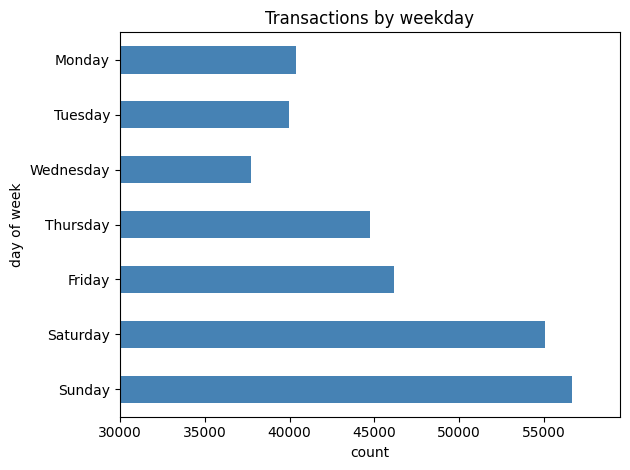

In [320]:
df['weekday'] = pd.to_datetime(df['timestamp']).dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_order.reverse()
df['weekday'] = pd.Categorical(df['weekday'], categories=weekday_order, ordered=True)
weekday_counts = df['weekday'].value_counts().sort_index()

weekday_counts.plot(kind='barh', color='steelblue')
plt.title('Transactions by weekday')
plt.xlabel('count')
plt.xlim(left=30000)
plt.ylabel('day of week')
plt.tight_layout()
plt.show()


chart below shows that Product #1 has the highest number of transactions

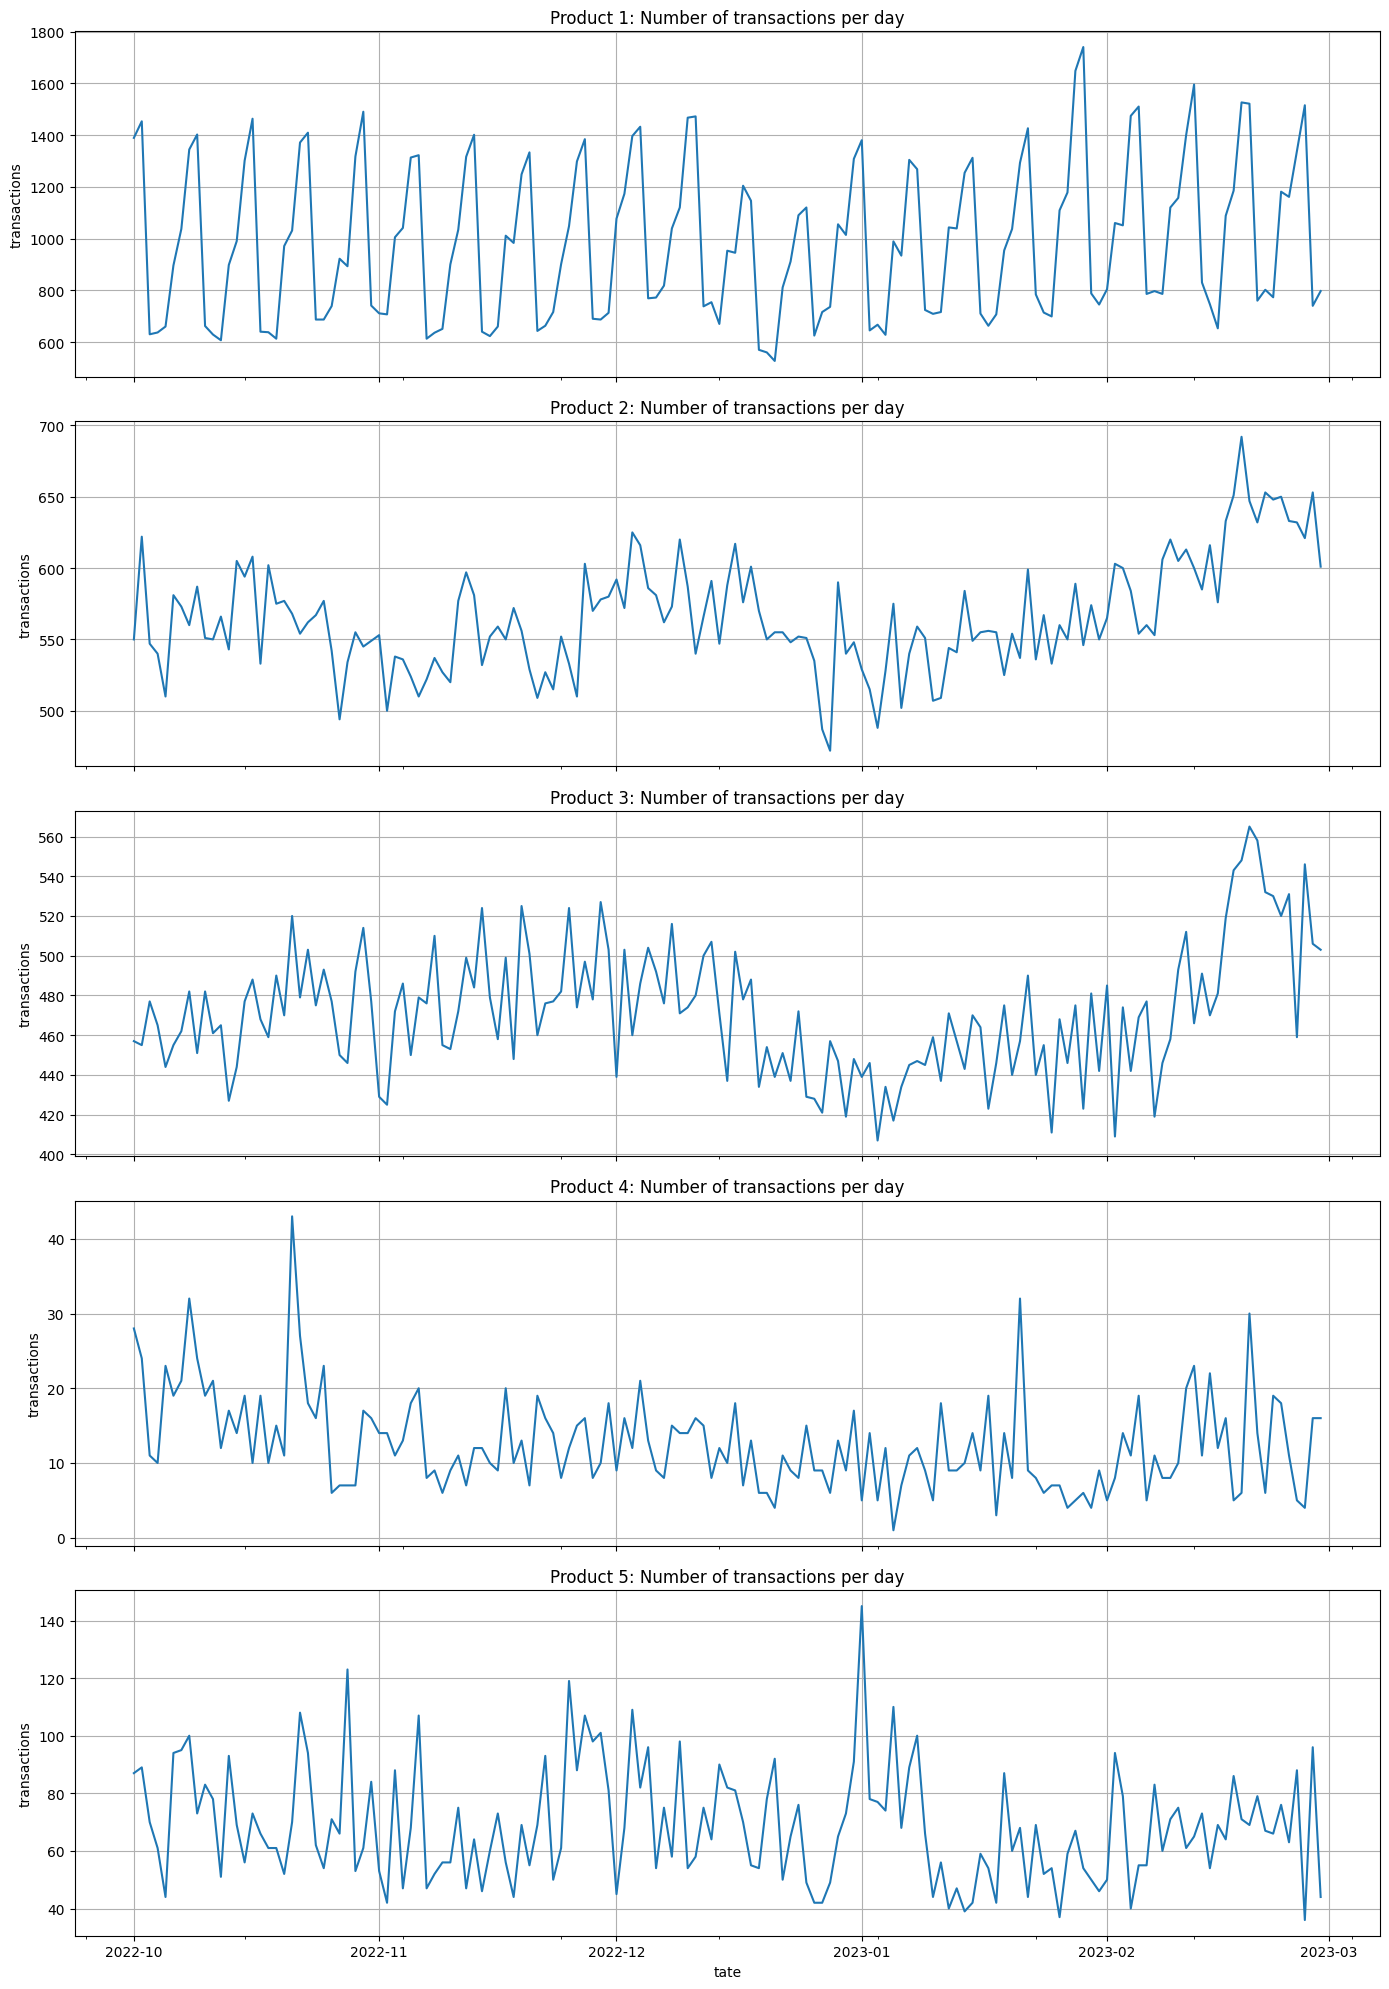

In [321]:
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

for i, product_id in enumerate([1, 2, 3, 4, 5]):
    product_df = df[df['product_type_id'] == product_id]
    daily_transactions = product_df.groupby('date').size()
    
    daily_transactions.plot(ax=axes[i], kind='line')
    axes[i].set_title(f'Product {product_id}: Number of transactions per day')
    axes[i].set_ylabel('transactions')
    axes[i].grid(True)

axes[-1].set_xlabel('tate')

plt.tight_layout()
plt.show()

## 2. Transactions overview

In [322]:
df_fail = df[df['status'] == 'fail']
df_chargeback = df[(df['status'] == 'success') & (df['is_chargeback'] == 1)]
df_refund = df[(df['status'] == 'success') & (df['is_refunded'] == 1)]
print(f"Percentage of transactions that did not bring money to the business {(df_fail.shape[0] + df_chargeback.shape[0] + df_refund.shape[0]) / df.shape[0]:.2f}")

Percentage of transactions that did not bring money to the business 0.86


90% of reccuring transactions are failed

54% of trial transactions are failed

In [323]:
df.groupby('charge_type')['status'].value_counts(normalize=True).unstack()

status,fail,success,verify
charge_type,,,
recurring,0.904649,0.094021,0.001330
trial,0.546095,0.129604,0.324301


## 3. Overview of European and non-European countries

In [324]:
european_countries = [
    'GBR', 'FRA', 'ESP', 'SWE', 'ITA', 'POL', 'IRL', 'FIN',
    'NLD', 'LTU', 'NOR', 'ROU', 'HRV', 'DNK', 'CZE', 'DEU',
    'AUT', 'SVK', 'BGR', 'LVA', 'PRT', 'GRC', 'HUN', 'ISL',
    'MLT', 'EST', 'GIB', 'LIE', 'BEL', 'SVN', 'LUX'
]
non_european = ['USA', 'AUS', 'CAN', 'NZL']

In [325]:
europe_df = df[df['card_country'].isin(european_countries)]
non_europe_df = df[df['card_country'].isin(non_european)]


In [326]:
european_groups  = europe_df.groupby("card_country")['user_id'].nunique().sort_values(ascending=False)
european_groups = european_groups[european_groups > 200]
non_european_groups = non_europe_df.groupby("card_country")['user_id'].nunique().sort_values(ascending=False)
# european_groups


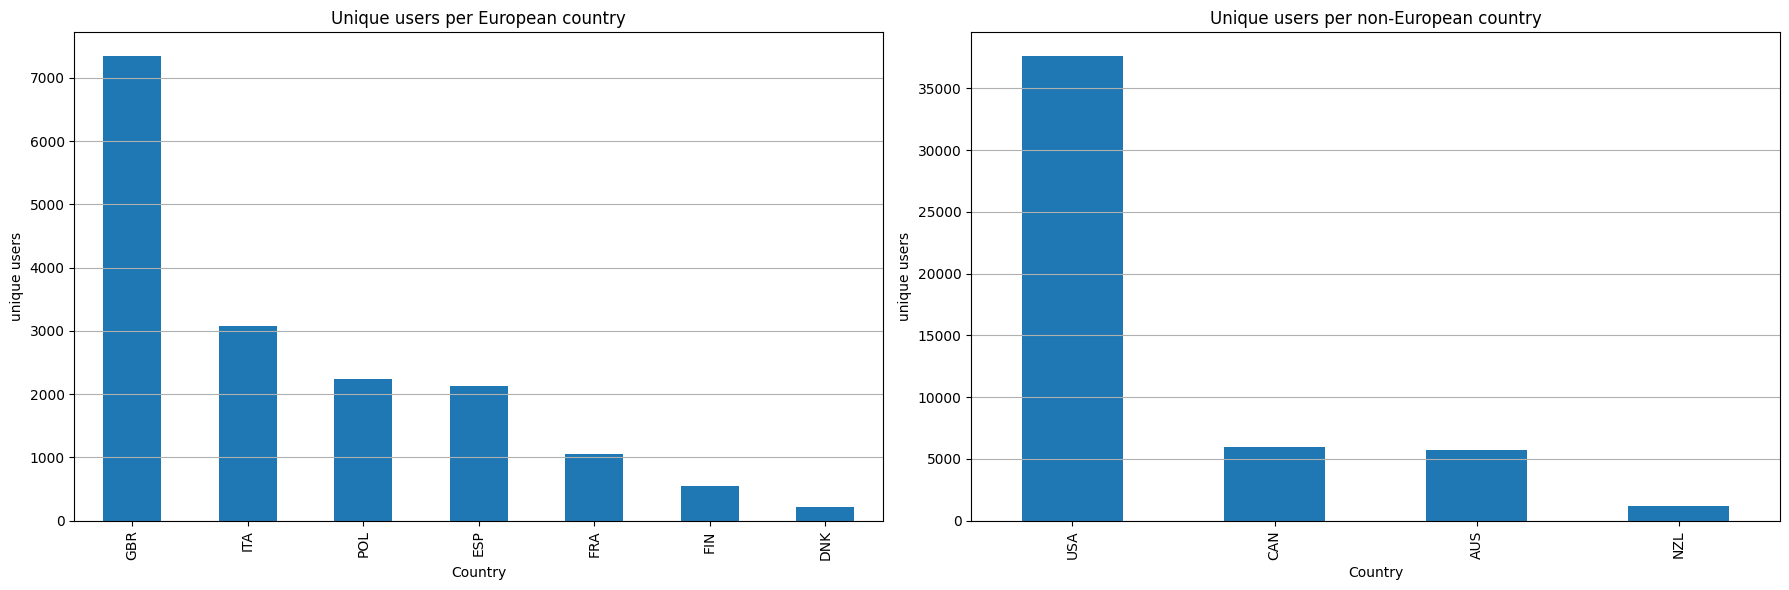

In [327]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

european_groups.plot(kind='bar', ax=axes[0])
axes[0].set_title('Unique users per European country')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('unique users')
axes[0].tick_params(axis='x', rotation=90)
axes[0].grid(axis='y')


non_european_groups.plot(kind='bar', ax=axes[1])
axes[1].set_title('Unique users per non-European country')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('unique users')
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

In [328]:
european_groups, non_european_groups

(card_country
 GBR    7352
 ITA    3074
 POL    2232
 ESP    2123
 FRA    1057
 FIN     542
 DNK     209
 Name: user_id, dtype: int64,
 card_country
 USA    37664
 CAN     5944
 AUS     5713
 NZL     1176
 Name: user_id, dtype: int64)

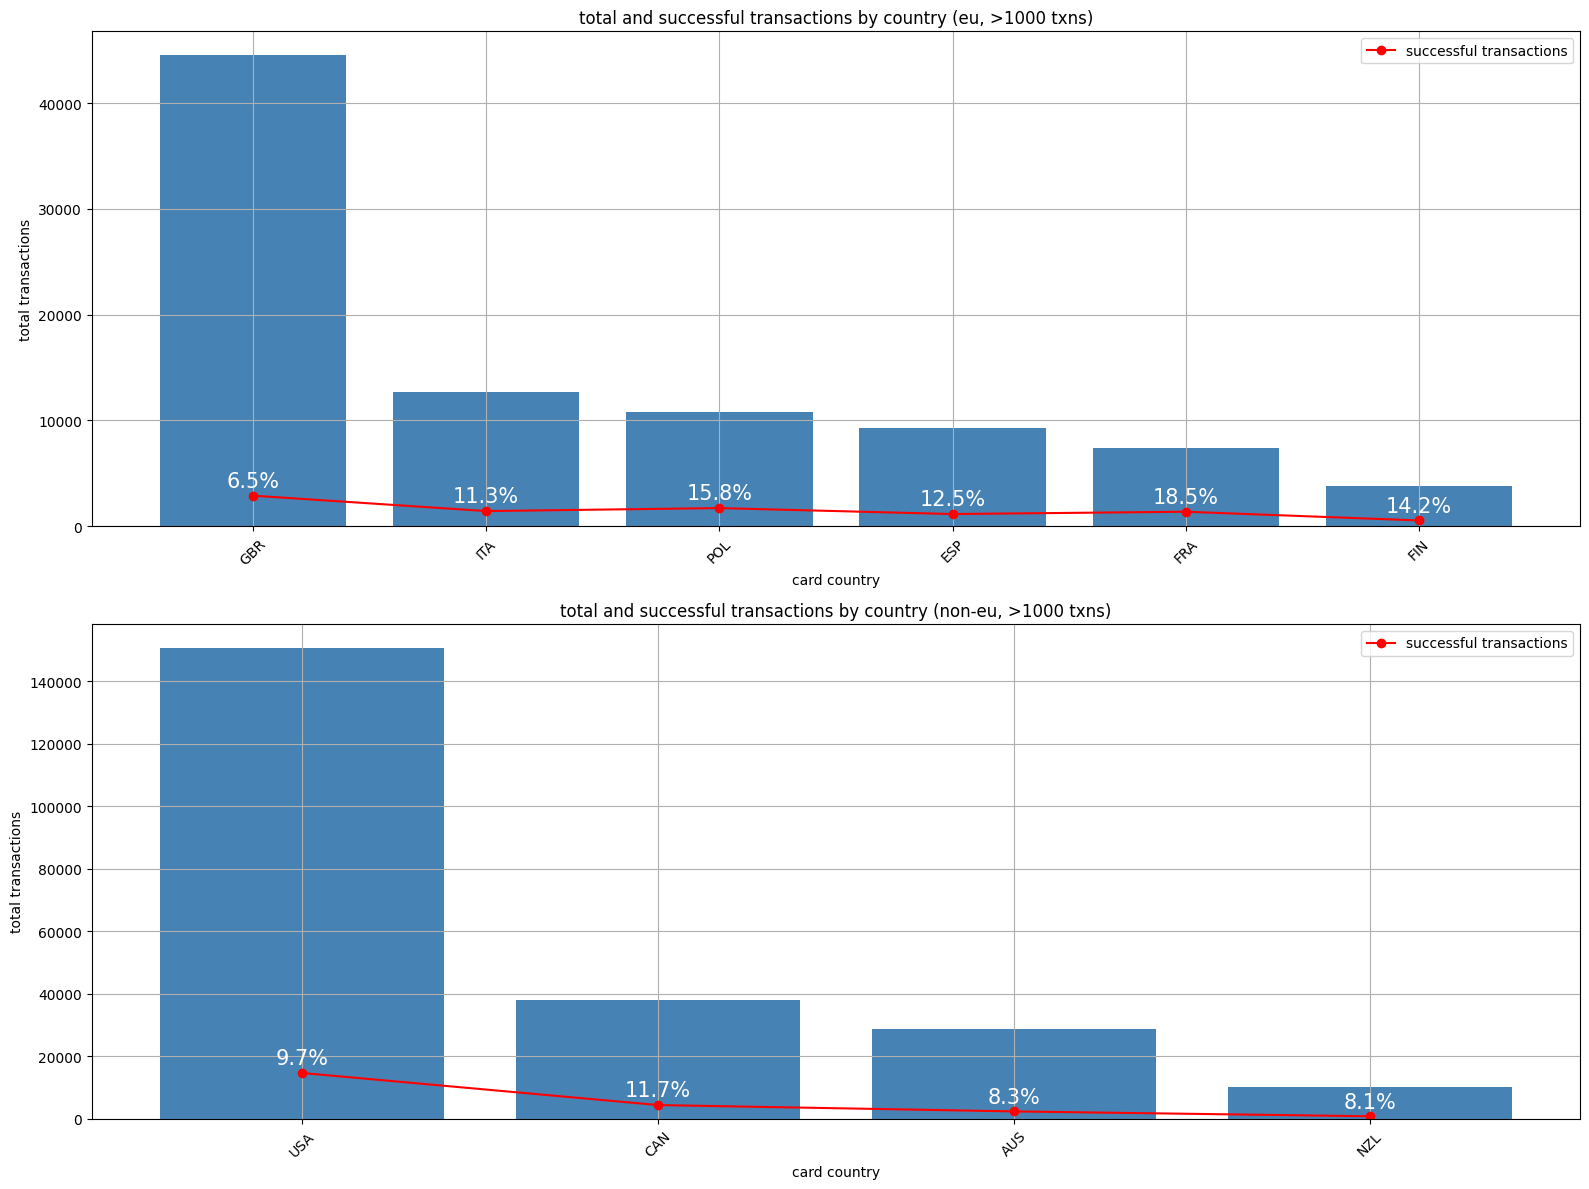

In [368]:
filtered_europe_df = europe_df[europe_df['status'].isin(['success', 'fail', 'verify'])]
filtered_non_europe_df = non_europe_df[non_europe_df['status'].isin(['success', 'fail', 'verify'])]

summary_eu = filtered_europe_df.groupby('card_country').agg(
    total_transactions=('status', 'count'),
    success_transactions=('status', lambda x: (x == 'success').sum())
)
summary_eu = summary_eu[summary_eu['total_transactions'] > 1000]
summary_eu['success_rate'] = (summary_eu['success_transactions'] / summary_eu['total_transactions'] * 100).round(1)
summary_eu = summary_eu.sort_values(by='total_transactions', ascending=False)

summary_non_eu = filtered_non_europe_df.groupby('card_country').agg(
    total_transactions=('status', 'count'),
    success_transactions=('status', lambda x: (x == 'success').sum())
)
summary_non_eu = summary_non_eu[summary_non_eu['total_transactions'] > 1000]
summary_non_eu['success_rate'] = (summary_non_eu['success_transactions'] / summary_non_eu['total_transactions'] * 100).round(1)
summary_non_eu = summary_non_eu.sort_values(by='total_transactions', ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

ax1.bar(summary_eu.index, summary_eu['total_transactions'], color='steelblue')
ax1.plot(summary_eu.index, summary_eu['success_transactions'], color='red', marker='o', label='successful transactions')
ax1.set_ylabel('total transactions')
ax1.set_xlabel('card country')
ax1.set_title('total and successful transactions by country (eu, >1000 txns)')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

for i, country in enumerate(summary_eu.index):
    y = summary_eu['success_transactions'].iloc[i]
    rate = summary_eu['success_rate'].iloc[i]
    ax1.text(i, y + max(summary_eu['total_transactions']) * 0.01, f'{rate}%', ha='center', va='bottom', color='white', fontsize=15)

ax1.legend(loc='upper right')

ax2.bar(summary_non_eu.index, summary_non_eu['total_transactions'], color='steelblue')
ax2.plot(summary_non_eu.index, summary_non_eu['success_transactions'], color='red', marker='o', label='successful transactions')
ax2.set_ylabel('total transactions')
ax2.set_xlabel('card country')
ax2.set_title('total and successful transactions by country (non-eu, >1000 txns)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True)

for i, country in enumerate(summary_non_eu.index):
    y = summary_non_eu['success_transactions'].iloc[i]
    rate = summary_non_eu['success_rate'].iloc[i]
    ax2.text(i, y + max(summary_non_eu['total_transactions']) * 0.01, f'{rate}%', ha='center', va='bottom', color='white', fontsize=15)

ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [331]:
approval_rate_eu = europe_df[europe_df['status'].isin(['success', 'fail', 'verify'])].groupby('card_country')['status'].value_counts(normalize=True).unstack().sort_values(by="success", ascending=False)
approval_rate_eu = approval_rate_eu.fillna(0)
# approval_rate_eu

In [332]:
approval_rate_non_eu = non_europe_df[non_europe_df['status'].isin(['success', 'fail', 'verify'])].groupby('card_country')['status'].value_counts(normalize=True).unstack()
approval_rate_non_eu = approval_rate_non_eu.fillna(0)
# approval_rate_non_eu

In [334]:
def products_summary(df):
    summary_by_produc = df.groupby('product_type_id').agg(
    number_of_transactions=('transactions_amount', 'count'),
    success_count=('status', lambda x: (x == 'success').sum()),
    fail_count=('status', lambda x: (x == 'fail').sum()),
    verify_count = ('status', lambda x: (x == 'verify').sum()),
    recurring_count=('charge_type', lambda x: (x == 'recurring').sum()),
    trial_count=('charge_type', lambda x: (x == 'trial').sum()),
    chargeback_count=('is_chargeback', 'sum'),
    refund_count=('is_refunded', 'sum'),
    ).reset_index()
    summary_by_produc ['success_rate_percent'] = (
        summary_by_produc ['success_count'] /
        (summary_by_produc ['success_count'] +
        summary_by_produc ['fail_count'] +
        summary_by_produc ['verify_count'])
    ) * 100
    summary_by_produc['refund_rate_percent'] = np.where(
    summary_by_produc['success_count'] > 0,
    (summary_by_produc['refund_count'] / summary_by_produc['success_count']) * 100, 0)


    return summary_by_produc[['product_type_id', 'number_of_transactions',  'success_count', 'success_rate_percent', 'refund_rate_percent']]

Approval rate of transactions by Europe and non Europe region

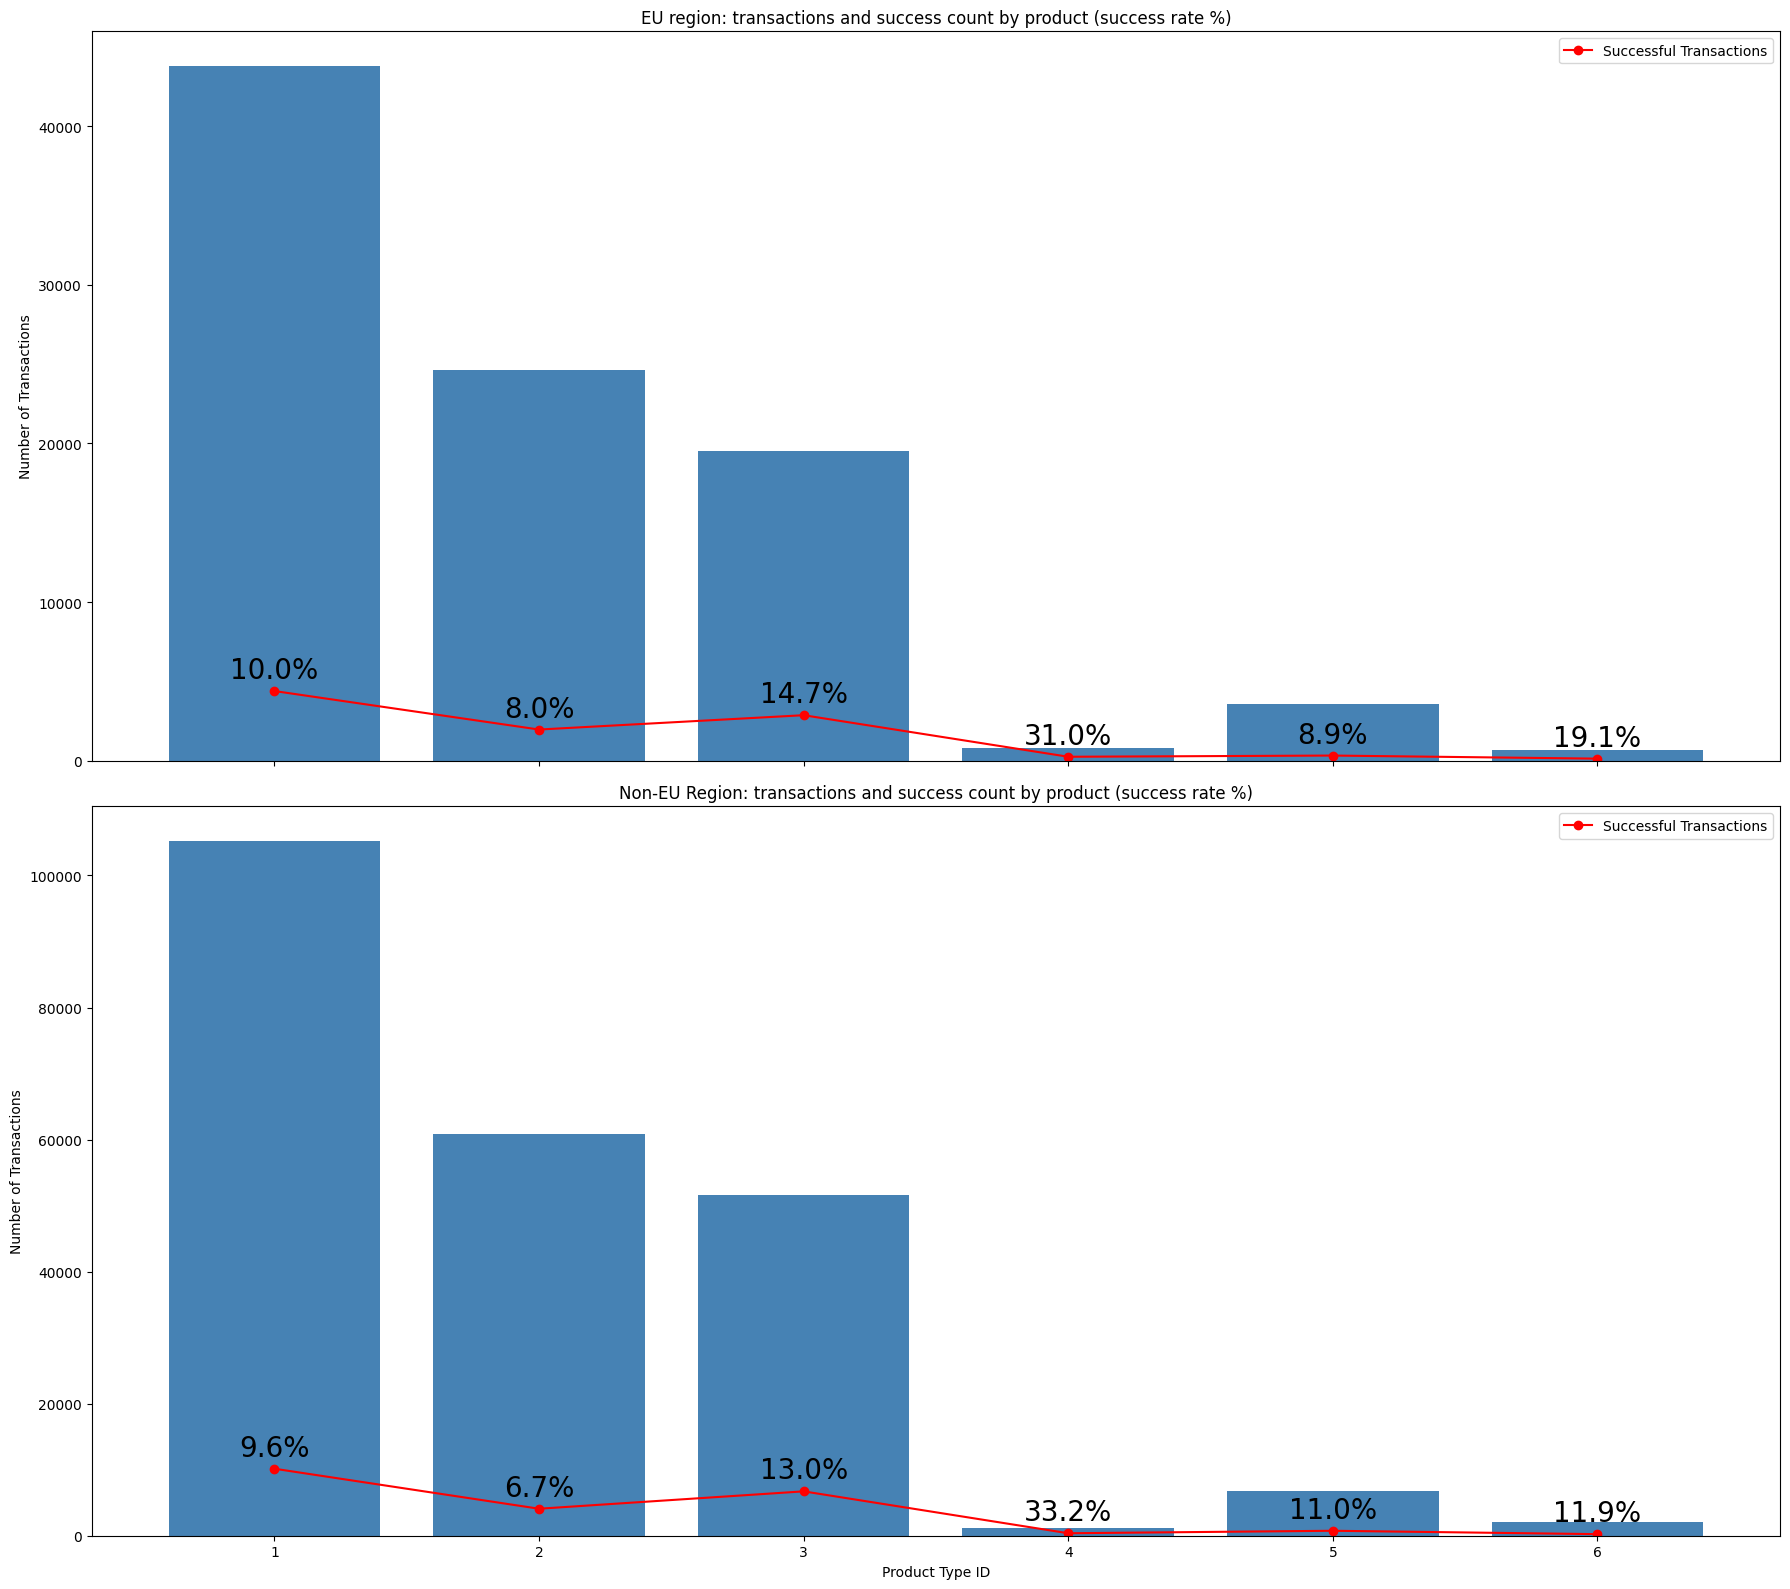

In [335]:
products_eu = products_summary(europe_df)
products_non_eu = products_summary(non_europe_df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 16), sharex=True)

ax1.bar(products_eu['product_type_id'], products_eu['number_of_transactions'], color='steelblue')
ax1.plot(products_eu['product_type_id'], products_eu['success_count'], color='red', marker='o', label='Successful Transactions')

for i in range(len(products_eu)):
    x = products_eu['product_type_id'].iloc[i]
    y = products_eu['success_count'].iloc[i]
    percent = products_eu['success_rate_percent'].iloc[i]
    ax1.text(x, y + max(products_eu['number_of_transactions']) * 0.01, f'{percent:.1f}%', ha='center', va='bottom', fontsize=20, color='black')

ax1.set_title('EU region: transactions and success сount by product (success rate %)')
ax1.set_ylabel('Number of Transactions')
ax1.legend(loc='upper right')

ax2.bar(products_non_eu['product_type_id'], products_non_eu['number_of_transactions'], color='steelblue')
ax2.plot(products_non_eu['product_type_id'], products_non_eu['success_count'], color='red', marker='o', label='Successful Transactions')

for i in range(len(products_non_eu)):
    x = products_non_eu['product_type_id'].iloc[i]
    y = products_non_eu['success_count'].iloc[i]
    percent = products_non_eu['success_rate_percent'].iloc[i]
    ax2.text(x, y + max(products_non_eu['number_of_transactions']) * 0.01, f'{percent:.1f}%', ha='center', va='bottom', fontsize=20, color='black')

ax2.set_title('Non-EU Region: transactions and success сount by product (success rate %)')
ax2.set_ylabel('Number of Transactions')
ax2.set_xlabel('Product Type ID')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

## 4. Overview of popular countries (USA, GBR, CAN, AUS, NZL, ITA, POL)

подивитись відсоток trial and recuuring on each product

In [371]:
pop_country_eu  = ['GBR', 'ITA', 'POL', 'ESP', 'FRA', 'FIN', 'FRA']
pop_country_non_eu = ['USA', 'CAN', 'AUS', 'NZL'] 

In [372]:
usa = df[df['card_country'] == 'USA']
can = df[df['card_country'] == 'CAN']
aus = df[df['card_country'] == 'AUS']
gbr= df[df['card_country'] == 'GBR']
nzl =  df[df['card_country'] == 'NZL']
pol =  df[df['card_country'] == 'POL']

### 4.1 USA

In [376]:
usa_banks = usa.groupby("card_country")['status'].count()
usa_banks 

card_country
USA    150705
Name: status, dtype: int64

Check is there is such bank, where percent of succesful transactions higher than 50% 

In [373]:
gbr_by_bank = gbr.groupby('card_bank').agg({
    'order_id': 'count', 
    'status': lambda x: (x == 'success').sum() / x.isin(['success', 'fail', 'verify']).sum(),
    'is_chargeback': 'mean'
}).sort_values(by='status', ascending=False)

gbr_by_bank = gbr_by_bank[gbr_by_bank['status'] > 0.5]

gbr_by_bank

,order_id,status,is_chargeback
card_bank,,,


In [352]:
can_by_bank = gbr.groupby('card_bank').agg({
    'order_id': 'count', 
    'status': lambda x: (x == 'success').sum() / x.isin(['success', 'fail', 'verify']).sum(),
    'is_chargeback': 'mean'
}).sort_values(by='status', ascending=False)

can_by_bank = can_by_bank[(can_by_bank['status'] > 0.5)]

can_by_bank

,order_id,status,is_chargeback
card_bank,,,


In [353]:
def get_most_subscribed_product(df):
    # recurring_df = df[(df['charge_type'] == 'recurring'
    #                         ) & (df['status'] == 'success') & (
    #                             df['is_chargeback'] == 0) & (
    #                                 df['is_refunded'] == 0 )]
    recurring_df = df[df['charge_type'] == 'recurring']

    recurring_counts = recurring_df['product_type_id'].value_counts()

    most_recurring_product = recurring_counts.idxmax()
    most_recurring_count = recurring_counts.max()
    return most_recurring_product, most_recurring_count

print(f"The most subscribed product in USA #{get_most_subscribed_product(can)[0]} (count: {get_most_subscribed_product(europe_df)[1]})")
# print(f"The most subscribed product in non Europe countries {get_most_subscribed_product(non_europe_df)[0]} (count: {get_most_subscribed_product(non_europe_df)[1]})")
# get_most_subscribed_product(non_europe_df)

The most subscribed product in USA #1 (count: 25713)


In [356]:
def get_most_subscribed_product(df):
    recurring_df = df[(df['charge_type'] == 'recurring'
                            ) & (df['status'] == 'success') & (
                                df['is_chargeback'] == 0) & (
                                    df['is_refunded'] == 0 )]

    recurring_counts = recurring_df['product_type_id'].value_counts()

    most_recurring_product = recurring_counts.idxmax()
    most_recurring_count = recurring_counts.max()
    return most_recurring_product, most_recurring_count

print(f"The most subscribed product in Europe countries {get_most_subscribed_product(europe_df)[0]} (count: {get_most_subscribed_product(europe_df)[1]})")
print(f"The most subscribed product in non Europe countries {get_most_subscribed_product(non_europe_df)[0]} (count: {get_most_subscribed_product(non_europe_df)[1]})")
get_most_subscribed_product(non_europe_df)

The most subscribed product in Europe countries 3 (count: 2576)
The most subscribed product in non Europe countries 3 (count: 5731)


(np.int64(3), np.int64(5731))

In [357]:
def get_most_triable_product(df):
    recurring_df = df[(df['charge_type'] == 'trial'
                            ) & (df['status'] == 'success') & (
                                df['is_chargeback'] == 0) & (
                                    df['is_refunded'] == 0 )]

    recurring_counts = recurring_df['product_type_id'].value_counts()
    # print(recurring_counts)

    most_recurring_product = recurring_counts.idxmax()
    most_recurring_count = recurring_counts.max()
    return most_recurring_product, most_recurring_count

print(f"The most subscribed product in Europe countries {get_most_triable_product(europe_df)[0]} (count: {get_most_triable_product(europe_df)[1]})")
print(f"The most subscribed product in non Europe countries {get_most_triable_product(non_europe_df)[0]} (count: {get_most_triable_product(non_europe_df)[1]})")
get_most_subscribed_product(non_europe_df)

The most subscribed product in Europe countries 1 (count: 1262)
The most subscribed product in non Europe countries 1 (count: 4266)


(np.int64(3), np.int64(5731))